In [2]:
from raw_python.Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from raw_python.BaggingSA import BaggingSA
from typing import Literal, Tuple
from raw_python.Bagging import predict
import sklearn
from raw_python.plots_manager import *
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from tabulate import tabulate
import seaborn as sns
from scipy.stats import *


# PARAMS

+------------------+------+-------+-------+--------------------+---------------------+---------------------+
|     Dataset      | Beta | Gamma | Delta |         FI         |     FitnessNorm     |    SpearmanCorr     |
+------------------+------+-------+-------+--------------------+---------------------+---------------------+
|  breast cancer   | 0.5  | 0.75  | 0.05  | 0.9532664762986846 | 0.48189137153569445 | 0.1209434347881912  |
|      digits      | 0.25 |  0.5  | 0.01  | 0.9401395466375296 | 0.5510493827160493  | 0.4281564063285969  |
|     obesity      | 0.25 | 0.25  | 0.05  | 0.9021292919811532 | 0.6992388121973174  | -0.7460043871928399 |
|       pima       | 0.75 | 0.25  | 0.01  | 0.6930388740066215 | 0.7167219341718029  | 0.04663892772035074 |
| students dropout | 0.25 | 0.25  | 0.05  | 0.6478403047183509 | 0.5618728000475506  | -0.0187210331175524 |
|       wine       | 0.75 |  0.5  | 0.01  | 0.9698198111988986 | 0.7785733882030179  | 0.1405009008888505  |
+------------------

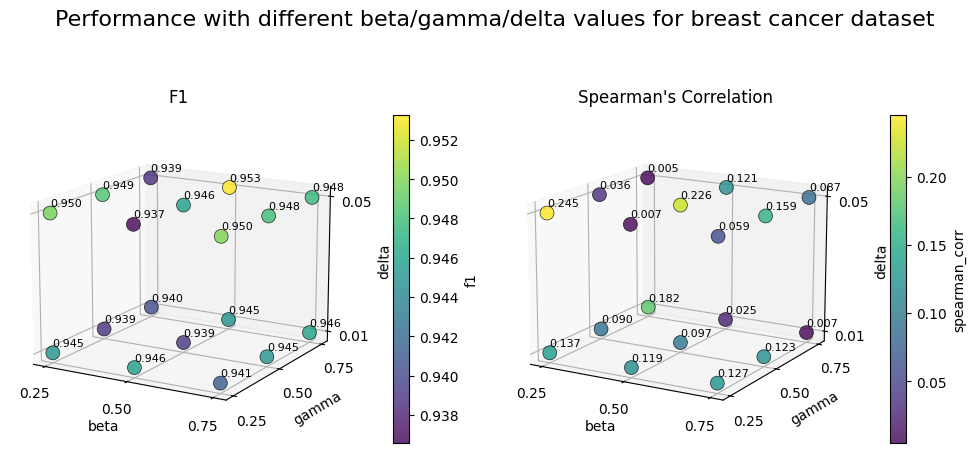

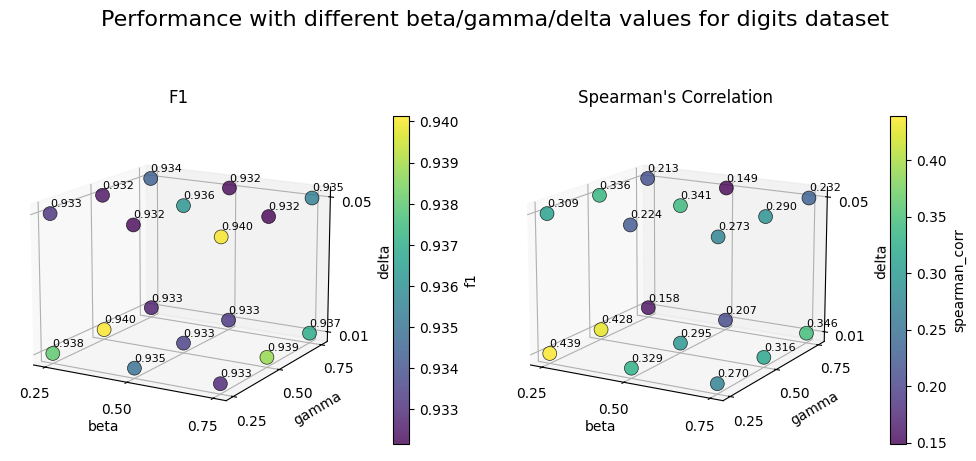

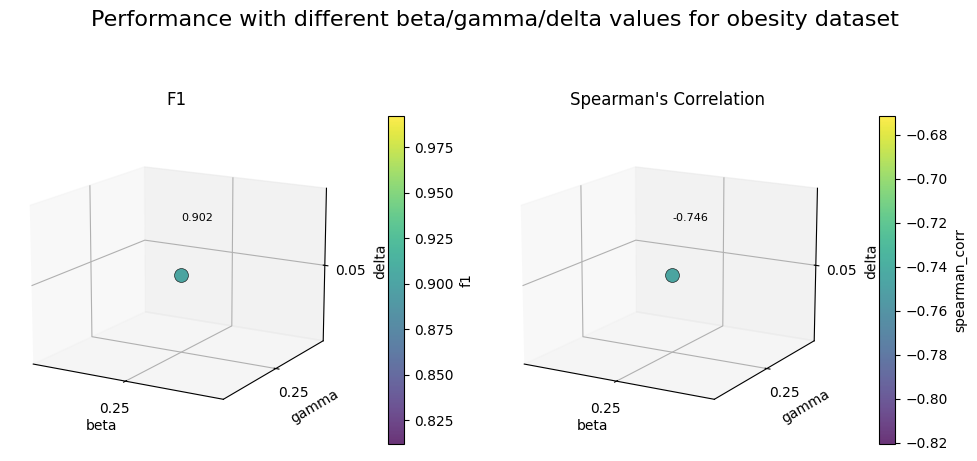

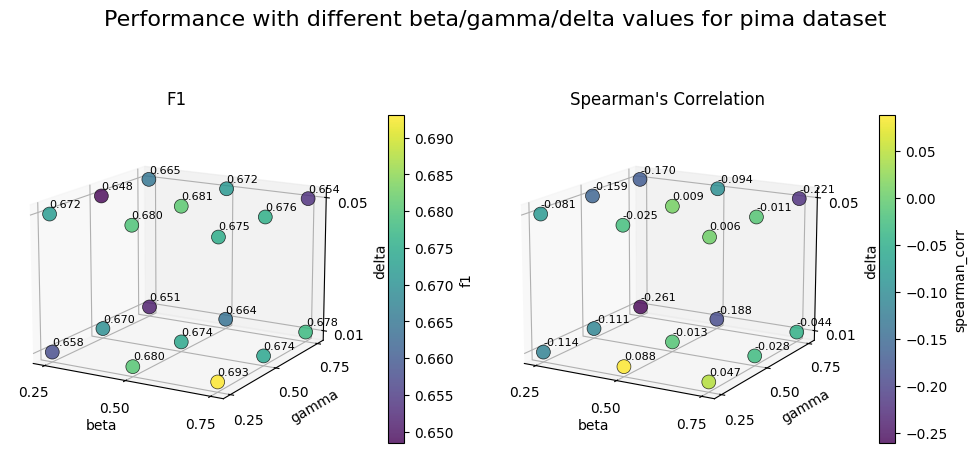

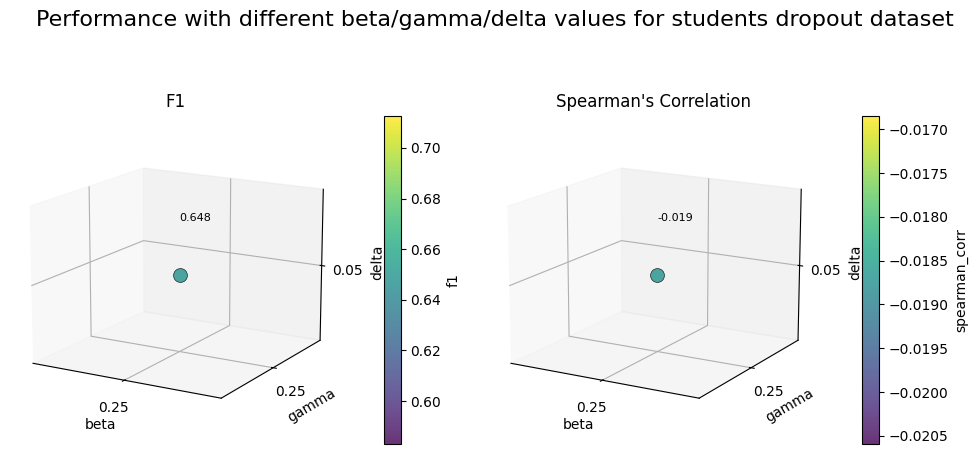

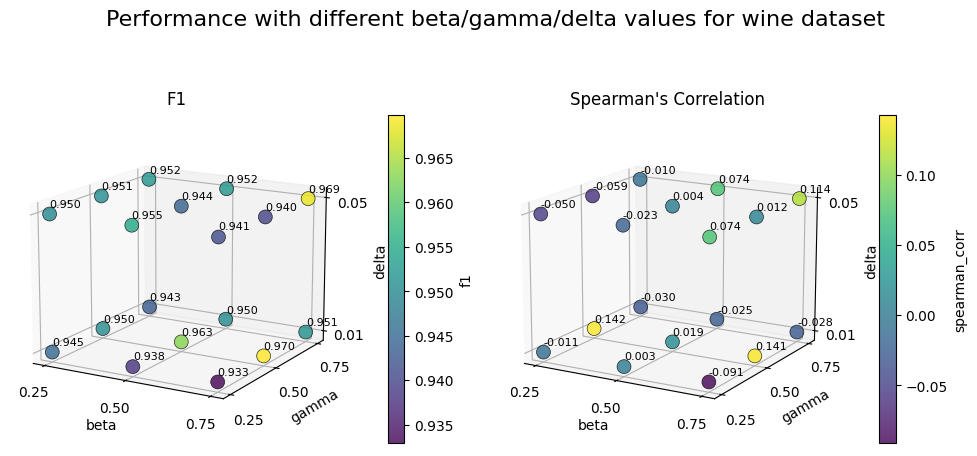

In [3]:
greeks = ['beta', 'gamma', 'delta']

files = glob.glob('./../res/params_*.csv')
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df = df[df['delta'] != 0.1]

df['dataset'] = df['dataset'].str.replace('_', ' ')



df['fitness_norm'] = (df['fitness']) / (df['beta'] + df['gamma'])

grouped = df.groupby(['dataset'] + greeks).agg({
    'f1': 'mean',
    'fitness_norm': 'mean',
    'spearman_corr': 'mean'
}).reset_index()

grouped_corr = df[df['spearman_p'] < 0.05].groupby(['dataset'] + greeks).agg({
    'f1': 'mean',
    'fitness_norm': 'mean',
    'spearman_corr': 'mean'
}).reset_index()


best_by_dataset = grouped.loc[grouped.groupby('dataset')['f1'].idxmax()].copy()
best_by_dataset = best_by_dataset.rename(columns={
        'dataset': 'Dataset',
        'beta': 'Beta',
        'gamma': 'Gamma',
        'delta': 'Delta',
        'f1': 'FI',
        'fitness_norm': 'FitnessNorm',
        'spearman_corr': "SpearmanCorr"
    })
print(tabulate(best_by_dataset, headers='keys', tablefmt='pretty', showindex=False))
best_by_dataset.to_csv('./../report/csv/best_greeks_by_dataset.csv', index=False)

# 3D Scatter Plot Function
def plot_metrics_3d_subplots(df, dataset, metrics, titles, themes, path):
    fig = plt.figure(figsize=(len(metrics)*5, 5))  # Adjust figure size for subplots
    fig.suptitle(f"Performance with different beta/gamma/delta values for {dataset} dataset", fontsize=16, x=0.5)
    for i, (metric, title, theme) in enumerate(zip(metrics, titles, themes), start=1):
        df_tmp = df[df['dataset'] == dataset]
        ax = fig.add_subplot(1, len(metrics), i, projection='3d')  # Create a subplot for each metric
        sc = ax.scatter(
            df_tmp[greeks[0]], 
            df_tmp[greeks[1]], 
            df_tmp[greeks[2]], 
            c=df_tmp[metric], 
            cmap=theme, 
            s=100, 
            depthshade=True,
            edgecolor='k',  # Add black edges to improve point visibility
            linewidth=0.5,
            alpha=0.8  # Slight transparency helps with overlapping points
        )
        ax.set_xlabel(greeks[0])
        ax.set_ylabel(greeks[1])
        ax.set_zlabel(greeks[2])
        ax.set_title(title)
        
        ax.set_xticks(df_tmp[greeks[0]].unique())
        ax.set_yticks(df_tmp[greeks[1]].unique())
        ax.set_zticks(df_tmp[greeks[2]].unique())
        
        # ax.grid(True, linestyle='--', alpha=0.5)
        # ax.view_init(elev=15, azim=30)
        ax.view_init(elev=15)
        
        # Adjust colorbar position and size
        cbar = fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.1)  # Shrink and add padding
        cbar.set_label(metric)
        
        # Add numeric annotations
        for _, row in df_tmp.iterrows():
            ax.text(row[greeks[0]], row[greeks[1]], row[greeks[2]]+.002, f"{row[metric]:.3f}", fontsize=8, color='black')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    if path != None:
        plt.savefig(path, bbox_inches='tight')
    plt.show()


datasets = grouped['dataset'].unique()

# Define metrics, titles, and themes for the subplots
metrics = ['f1', 'spearman_corr']
titles = [
    'F1',
    "Spearman\'s Correlation"
]
themes = ['viridis', 'viridis', 'viridis']

# Generate subplots for each dataset
for dataset in datasets:
    plot_metrics_3d_subplots(grouped, dataset, metrics, titles, themes, f'./../report/plt/plot_{dataset.replace(' ', '_')}_greeks.png')
    tmp = grouped[grouped['dataset'] == dataset]
    tmp = tmp.sort_values(by=['f1'], ascending=False)
    tmp = tmp.rename(columns={
        'beta': 'Beta',
        'gamma': 'Gamma',
        'delta': 'Delta',
        'f1': 'F1',
        'fitness_norm': 'FitnessNorm',
        'spearman_corr': "SpearmanCorr"
    })
    # tmp.to_csv(f'./../report/csv/table_{dataset}_greeks.csv', index=False)

# RESULT COMPARISON PLOTS  

In [4]:
def create_comparison_plot(df: pd.DataFrame, metric, path) -> None:
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    plt.figure(figsize=(12, 4))
    
    X = df['nTrees'].unique()
    dataset_name = df['Dataset'].values[0]
    
    y_data=[
        (f"Bagging{metric}", "Bagging"),
        (f"SA{metric}", "Bagging SA")
    ]

    for df_name, plt_name in y_data:
        Y, Y_std = df[df_name], df[df_name + "STD"]
        plt.plot(X, Y, marker='o', label=plt_name)
        plt.fill_between(X, Y - Y_std, Y + Y_std, alpha=0.1)

    plt.title(f"{metric} per trees amount for dataset: {dataset_name}")
    plt.xlabel('Number of Trees')
    plt.ylabel(f'{metric}')
    plt.legend()
    plt.xticks(X)
    plt.grid()
    
    if path != None:
        plt.savefig(path, bbox_inches='tight')
    plt.show()
    
def create_combined_box_plots(metric_data_list, dataset_name: str, path: str = None):
    sns.set_theme(style="ticks", palette='pastel')
    
    x_len = int(np.sqrt(len(metric_data_list)))
    y_len = int(np.ceil(len(metric_data_list) / x_len))
    
    fig, axes = plt.subplots(nrows=y_len, ncols=x_len, figsize=(12, 8))
    axes = axes.flatten()

    for i, (metric, df) in enumerate(metric_data_list):
        df_long = pd.melt(
            df,
            id_vars=['nTrees', 'Dataset'],
            value_vars=[f'Bagging{metric}', f'SA{metric}'],
            var_name='Method',
            value_name=metric
        )
        df_long['Method'] = df_long['Method'].replace({
            f'Bagging{metric}': 'Bagging',
            f'SA{metric}': 'Bagging SA'
        })

        sns.boxplot(data=df_long, x='nTrees', y=metric, hue='Method', ax=axes[i])
        sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',
                      dodge=True, color='black', alpha=0.8, jitter=True, ax=axes[i])

        # Clean up legend
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend(handles[:2], labels[:2], title='Method')
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_xlabel('Number of Trees')
        axes[i].set_ylabel(metric)
        axes[i].grid(axis='y', linestyle='--', linewidth=0.5)

    plt.suptitle(f'Metric comparison across methods ({dataset_name})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle

    if path:
        plt.savefig(path, bbox_inches='tight')
    plt.show()
    
    
    

    
def stat_tests(df: pd.DataFrame, metric):
    res = []
    for nTrees in df['nTrees'].unique():
        data = df[df['nTrees'] == nTrees]
        shp_bagg = shapiro(data[f'Bagging{metric}']).pvalue
        shp_sa = shapiro(data[f'SA{metric}']).pvalue
        
        if shp_bagg < 0.05 or shp_sa < 0.05:
            levene_tmp = levene(data[f'Bagging{metric}'], data[f'SA{metric}'], center='median').pvalue
            levene_res = f'Levene (median): {levene_tmp:.3f}'
        else:
            levene_tmp = levene(data[f'Bagging{metric}'], data[f'SA{metric}'], center='mean').pvalue
            levene_res = f'Levene (mean): {levene_tmp:.3f}'
            
        
        if shp_bagg >= 0.05 and shp_sa >= 0.05 and levene_tmp >= 0.05:
            comp_tmp = ttest_ind(data[f'Bagging{metric}'], data[f'SA{metric}'], equal_var=True).pvalue
            comp_res = f'T-test (equal var): {comp_tmp:.3f}'
        elif shp_bagg >= 0.05 and shp_sa >= 0.05 and levene_tmp < 0.05:
            comp_tmp = ttest_ind(data[f'Bagging{metric}'], data[f'SA{metric}'], equal_var=False).pvalue
            comp_res = f'T-test (unequal var): {comp_tmp:.3f}'
        else:
            comp_tmp = mannwhitneyu(data[f'Bagging{metric}'], data[f'SA{metric}']).pvalue
            comp_res = f'Mann-Whitney: {comp_tmp:.3f}'
        
        
        res.append([
            nTrees, f'Shapiro: {shp_bagg:.3f}', f'Shapiro: {shp_sa:.3f}', levene_res, comp_res, 
            'H0 rejected' if comp_tmp < 0.05 else 'H0 accepted'
        ])

    res_df = pd.DataFrame(res, columns=['nTrees', 'BaggingNormality', 'SANormality', 'VarianceTest', 'ComparisonTest', 'Result'])    
    return res_df
        
    

DATASET= pima | METRIC= Accuracy
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |  BaggingAccuracy   |     SAAccuracy     |  BaggingAccuracySTD  |    SAAccuracySTD     |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
|  pima   |   10   | 0.7450878533231474 | 0.7284101519395637 | 0.029035081032944752 | 0.024878254312654554 |
|  pima   |   20   | 0.7628096086919617 | 0.7404006451065274 | 0.030278128256664316 | 0.028604493982372154 |
|  pima   |   30   | 0.7638842203548086 | 0.7495051353874884 | 0.03367319999867683  | 0.024133119420812792 |
|  pima   |   40   | 0.764111705288176  | 0.7549630761395467 | 0.03188222669997819  | 0.02698744326544518  |
|  pima   |   50   | 0.7638621509209744 | 0.7531975214328156 | 0.031438783076732583 | 0.03752509974752971  |
+---------+--------+--------------------+--------------------+----------------------+----------

/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',
/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',


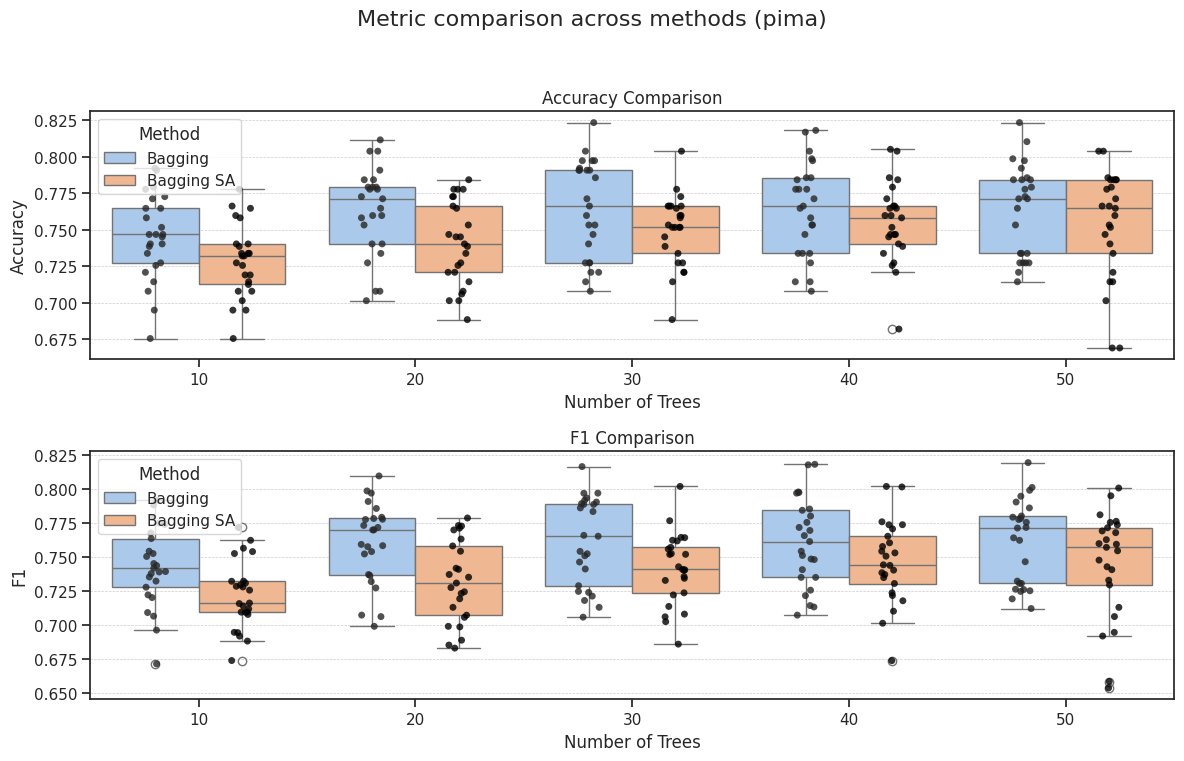

DATASET= breast cancer | METRIC= Accuracy
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
|    Dataset    | nTrees |  BaggingAccuracy   |     SAAccuracy     |  BaggingAccuracySTD  |    SAAccuracySTD     |
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
| breast cancer |   10   | 0.9500729700357087 | 0.9514733736997362 | 0.01929779231208628  | 0.015972410781093786 |
| breast cancer |   20   | 0.9570936190032604 | 0.9567396367023754 | 0.015354536838902973 | 0.019039798726975365 |
| breast cancer |   30   | 0.9560440925322155 | 0.9542928116752057 | 0.015690819894974527 |  0.0148318512097577  |
| breast cancer |   40   | 0.9546436888681882 | 0.9560409874243131 | 0.013615024038298314 | 0.01707799819312604  |
| breast cancer |   50   | 0.9546405837602857 | 0.9553516534699581 | 0.01843431348225226  | 0.013689182440123873 |
+---------------+--------+------------

/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',
/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',


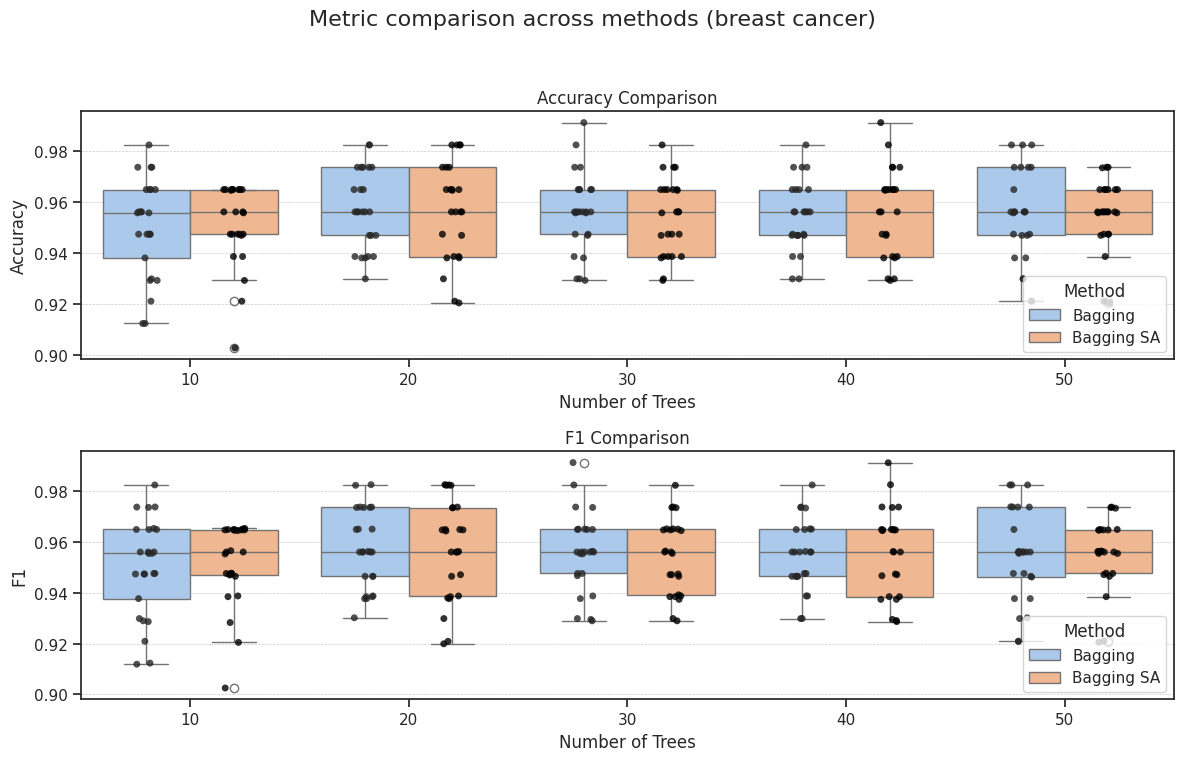

DATASET= obesity | METRIC= Accuracy
+---------+--------+--------------------+--------------------+---------------------+----------------------+
| Dataset | nTrees |  BaggingAccuracy   |     SAAccuracy     | BaggingAccuracySTD  |    SAAccuracySTD     |
+---------+--------+--------------------+--------------------+---------------------+----------------------+
| obesity |   10   | 0.9489466273776045 | 0.9515752349438612 | 0.00978111243622045 | 0.013105435549251157 |
+---------+--------+--------------------+--------------------+---------------------+----------------------+
STATS
+--------+------------------+----------------+------------------------+---------------------+-------------+
| nTrees | BaggingNormality |  SANormality   |      VarianceTest      |   ComparisonTest    |   Result    |
+--------+------------------+----------------+------------------------+---------------------+-------------+
|   10   |  Shapiro: 0.469  | Shapiro: 0.004 | Levene (median): 0.817 | Mann-Whitney: 0.198 | 

/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',
/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',


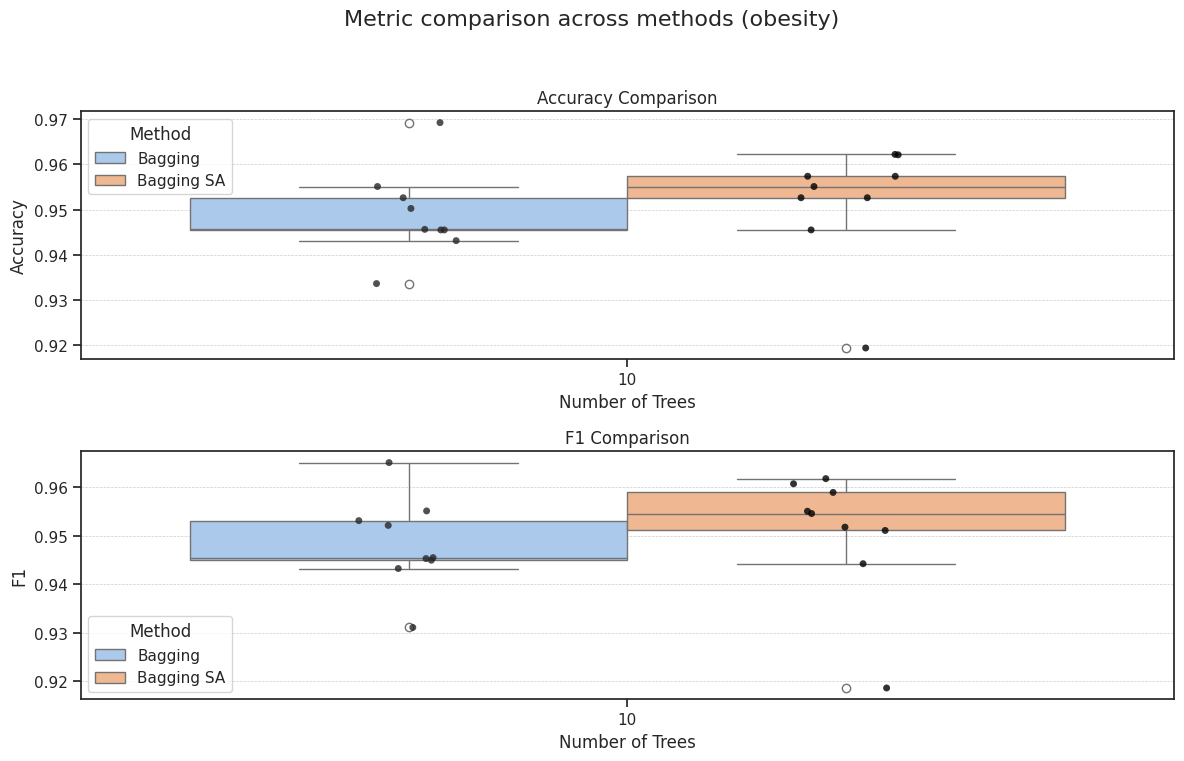

DATASET= wine | METRIC= Accuracy
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |  BaggingAccuracy   |     SAAccuracy     |  BaggingAccuracySTD  |    SAAccuracySTD     |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
|  wine   |   10   | 0.9494920634920635 | 0.9527936507936507 | 0.031100311266612016 | 0.03421233328867205  |
|  wine   |   20   | 0.9506349206349206 | 0.9594920634920635 | 0.03885445511505379  | 0.036425516580653544 |
|  wine   |   30   | 0.9606666666666667 | 0.9684761904761905 | 0.037921284940201014 | 0.026067451960908542 |
|  wine   |   40   | 0.9584761904761905 | 0.9627301587301588 | 0.04193584004691067  | 0.025591884854788652 |
|  wine   |   50   | 0.9652063492063492 | 0.9684126984126984 | 0.039782070945644336 | 0.023541257658148157 |
+---------+--------+--------------------+--------------------+----------------------+----------

/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',
/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',


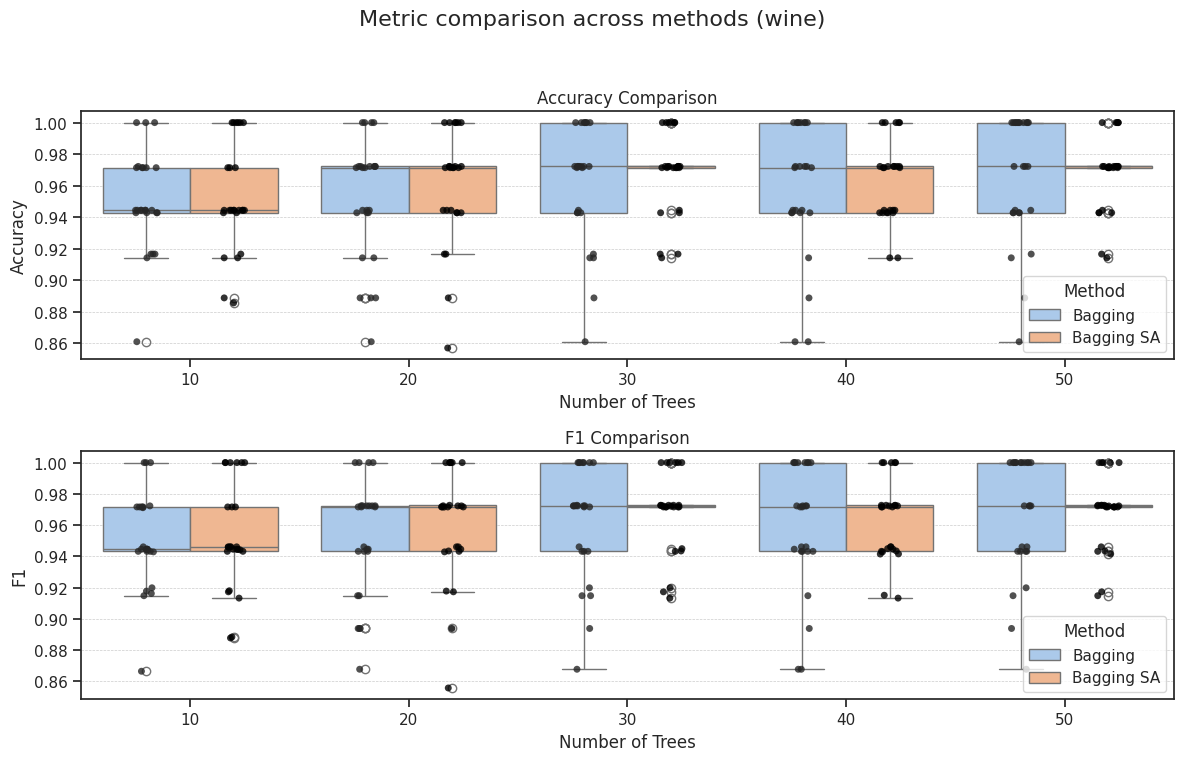

DATASET= digits | METRIC= Accuracy
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |  BaggingAccuracy   |     SAAccuracy     |  BaggingAccuracySTD  |    SAAccuracySTD     |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| digits  |   10   | 0.9284311358712474 | 0.9327613741875581 | 0.015843632086564505 | 0.020515235874037644 |
| digits  |   20   | 0.9377765397709688 | 0.9505756731662024 | 0.012198648984862063 | 0.014433998514852492 |
| digits  |   30   | 0.9389990714948933 | 0.9536898792943361 | 0.011940355140470352 | 0.012035010670396126 |
| digits  |   40   | 0.9383348808418447 | 0.9533574744661095 | 0.011045263178248811 | 0.010491949578409536 |
| digits  |   50   | 0.9418932219127205 | 0.9565908387496131 | 0.012346168421669365 | 0.009282424499107322 |
+---------+--------+--------------------+--------------------+----------------------+--------

/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',
/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_long, x='nTrees', y=metric, hue='Method',


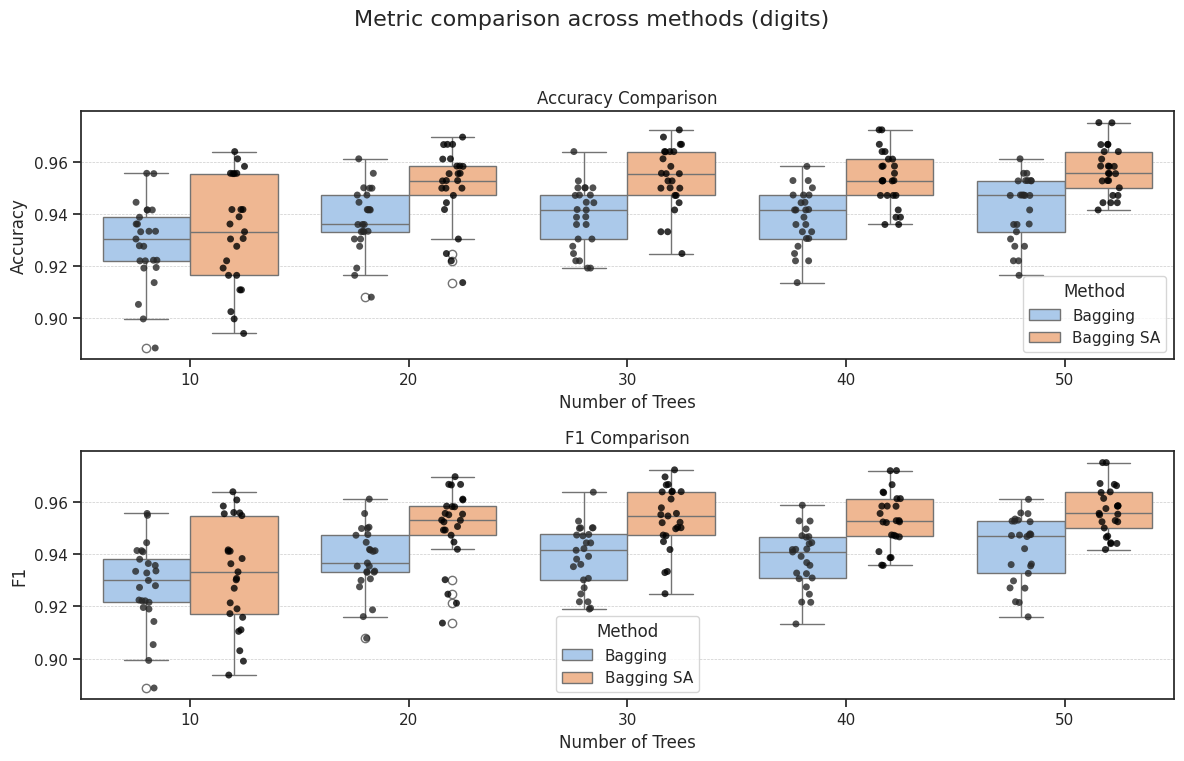

DATASET= students dropout | METRIC= Accuracy
+------------------+--------+--------------------+--------------------+---------------------+----------------------+
|     Dataset      | nTrees |  BaggingAccuracy   |     SAAccuracy     | BaggingAccuracySTD  |    SAAccuracySTD     |
+------------------+--------+--------------------+--------------------+---------------------+----------------------+
| students dropout |   10   | 0.7338983050847457 | 0.7350282485875705 | 0.00719091641884629 | 0.005592934992435973 |
+------------------+--------+--------------------+--------------------+---------------------+----------------------+
STATS
+--------+------------------+--------------+----------------------+---------------------+-------------+
| nTrees | BaggingNormality | SANormality  |     VarianceTest     |   ComparisonTest    |   Result    |
+--------+------------------+--------------+----------------------+---------------------+-------------+
|   10   |   Shapiro: nan   | Shapiro: nan | Levene 

/tmp/ipykernel_6495/1614773253.py:78: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  shp_bagg = shapiro(data[f'Bagging{metric}']).pvalue
/tmp/ipykernel_6495/1614773253.py:79: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  shp_sa = shapiro(data[f'SA{metric}']).pvalue
/tmp/ipykernel_6495/1614773253.py:78: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  shp_bagg = shapiro(data[f'Bagging{metric}']).pvalue
/tmp/ipykernel_6495/1614773253.py:79: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  shp_sa = shapiro(data[f'SA{metric}']).pvalue
/tmp/ipykernel_6495/1614773253.py:52: FutureWarning: 

Setting a gradi

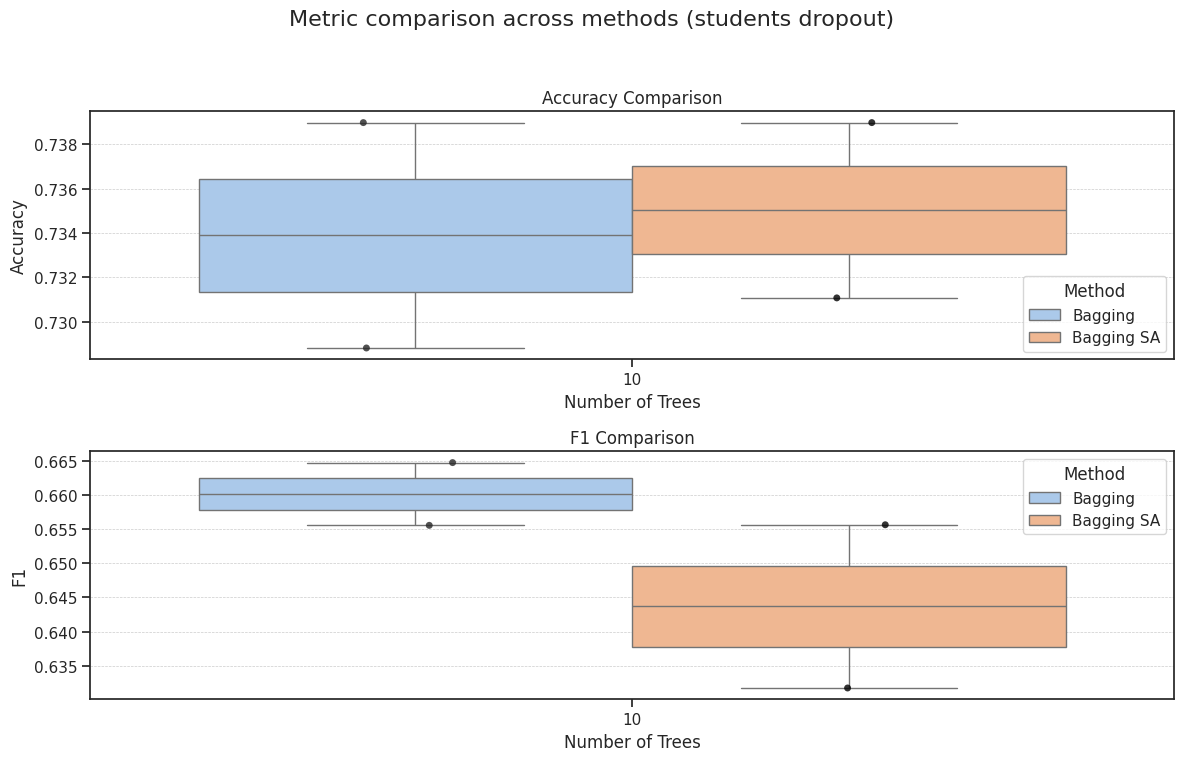

In [5]:

files = glob.glob('./../res/metrics_*.csv')
dfs = [pd.read_csv(f) for f in files]


# metrics = ["Accuracy", "Precision", "Recall", "F1"]
metrics = ["Accuracy", "F1"]

for df in dfs:
    df['Dataset'] = df['Dataset'].str.replace('_', ' ')
    dataset = df['Dataset'].values[0]
    aggregated_results = []
    aggregated_tables = None
    for metric in metrics:
        df_aggregated = df.groupby(['nTrees']).agg({
            'Dataset': 'first',
            'nTrees': 'first',
            f'Bagging{metric}': 'mean',
            f'SA{metric}': 'mean',
        }).reset_index(drop=True)

        df_aggregated[f'Bagging{metric}STD'] = df.groupby(['nTrees'])[f'Bagging{metric}'].std().values
        df_aggregated[f'SA{metric}STD'] = df.groupby(['nTrees'])[f'SA{metric}'].std().values
        print(f"DATASET= {dataset} | METRIC= {metric}")
        print(tabulate(df_aggregated, headers='keys', tablefmt='pretty', showindex=False))
        # df_aggregated.to_csv(f'./../report/csv/metrics_{dataset}_{metric}.csv', index=False)
        if aggregated_tables is None:
            aggregated_tables = df_aggregated
        else:
            aggregated_tables = pd.merge(aggregated_tables, df_aggregated, on=['nTrees', 'Dataset'], how='outer')

        print("STATS")
        stats = stat_tests(df, metric)
        print(tabulate(stats, headers='keys', tablefmt='pretty', showindex=False))
        stats.to_csv(f'./../report/csv/stats_{dataset.replace(' ', '_')}_{metric}.csv', index=False)


        aggregated_results.append((metric, df.copy()))  # store original df for plotting

    # Create combined plot after all metrics
    create_combined_box_plots(aggregated_results, dataset, path=f'./../report/plt/boxplot_combined_{dataset.replace(' ', '_')}.png')
    aggregated_tables.to_csv(f'./../report/csv/metrics_{dataset.replace(' ', '_')}_combined.csv', index=False)
